In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
df = pd.read_csv("credit_card_fraud_100k_with_features.csv", parse_dates = ['transaction_datetime'])

df.shape

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D44045CD-B874-3A27-9A61-F131D99AACE4> /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s  0:00:00

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
df.columns.tolist()

['transaction_id',
 'user_id',
 'transaction_datetime',
 'amount',
 'amount_log',
 'hour',
 'dayofweek',
 'is_weekend',
 'is_night',
 'merchant_id',
 'merchant_category',
 'merchant_category_code',
 'merchant_mean_amt',
 'merchant_tx_count',
 'merchant_base_fraud',
 'device',
 'device_code',
 'payment_method',
 'payment_method_code',
 'channel',
 'user_country',
 'user_account_age_days',
 'user_avg_amount',
 'user_mean_amt',
 'user_std_amt',
 'user_median_amt',
 'cnt_1h_prev',
 'cnt_24h_prev',
 'cnt_7d_prev',
 'sum_1h_prev',
 'sum_24h_prev',
 'sum_7d_prev',
 'time_since_prev_tx_sec',
 'is_first_tx',
 'device_change',
 'consec_same_merchant',
 'user_tx_count_sofar',
 'user_cum_amount_sofar',
 'user_avg_amount_prev',
 'dist_from_home_km',
 'dist_merchant_to_home_km',
 'dist_prev_tx_km',
 'is_far_from_home',
 'switched_country',
 'amount_zscore_user',
 'is_high_amount_user',
 'sum_24h_to_user_mean_ratio',
 'amount_to_merchant_mean_ratio',
 'amount_to_user_mean_ratio',
 'prior_fraud_flag',

In [14]:
df.isnull().sum().sort_values(ascending = False).head(20)

transaction_id              0
user_id                     0
cnt_7d_prev                 0
sum_1h_prev                 0
sum_24h_prev                0
sum_7d_prev                 0
time_since_prev_tx_sec      0
is_first_tx                 0
device_change               0
consec_same_merchant        0
user_tx_count_sofar         0
user_cum_amount_sofar       0
user_avg_amount_prev        0
dist_from_home_km           0
dist_merchant_to_home_km    0
dist_prev_tx_km             0
is_far_from_home            0
switched_country            0
amount_zscore_user          0
is_high_amount_user         0
dtype: int64

In [16]:
df.describe(include = 'all').T.head(10)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
transaction_id,100000,100000,TX0002930,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,100000,8000,U100505,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transaction_datetime,100000,NaN,NaN,NaN,2024-10-30 18:30:51.027010048,2024-01-01 00:03:04,2024-05-31 01:15:46.500000,2024-10-30 19:08:42,2025-03-31 08:35:05,2025-08-31 23:59:17,NaN
amount,100000.0,NaN,NaN,NaN,82.51277,0.5,13.79,44.48,97.57,30583.56,201.477624
amount_log,100000.0,NaN,NaN,NaN,3.457294,0.405465,2.693951,3.817273,4.590767,10.328251,1.642904
hour,100000.0,NaN,NaN,NaN,11.53217,0.0,6.0,12.0,18.0,23.0,6.921181
dayofweek,100000.0,NaN,NaN,NaN,3.01134,0.0,1.0,3.0,5.0,6.0,2.004578
is_weekend,100000.0,NaN,NaN,NaN,0.28915,0.0,0.0,0.0,1.0,1.0,0.45337
is_night,100000.0,NaN,NaN,NaN,0.2066,0.0,0.0,0.0,0.0,1.0,0.404868
merchant_id,100000,3000,M101610,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
fraud_rate = df['is_fraud'].mean()
fraud_rate

np.float64(0.006)

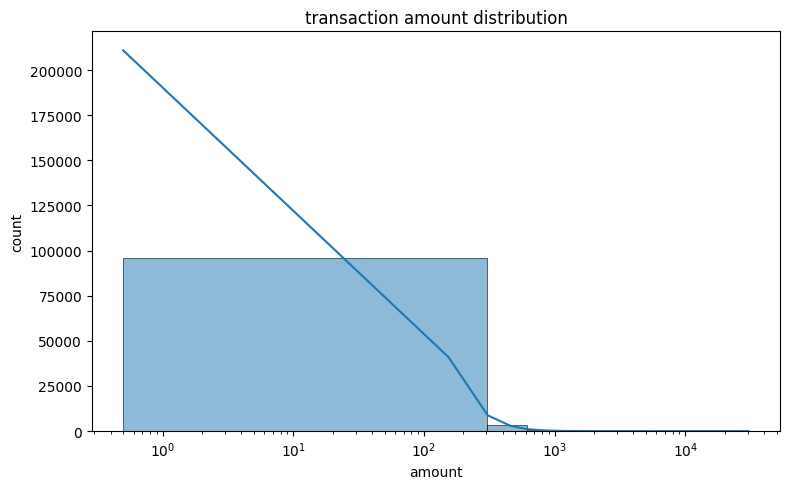

In [24]:

plt.figure(figsize = (8,5))
sns.histplot(df['amount'],bins = 100, kde = True)
plt.title('transaction amount distribution')
plt.xlabel('amount')
plt.ylabel('count')
plt.xscale('log')
plt.tight_layout()
plt.show()






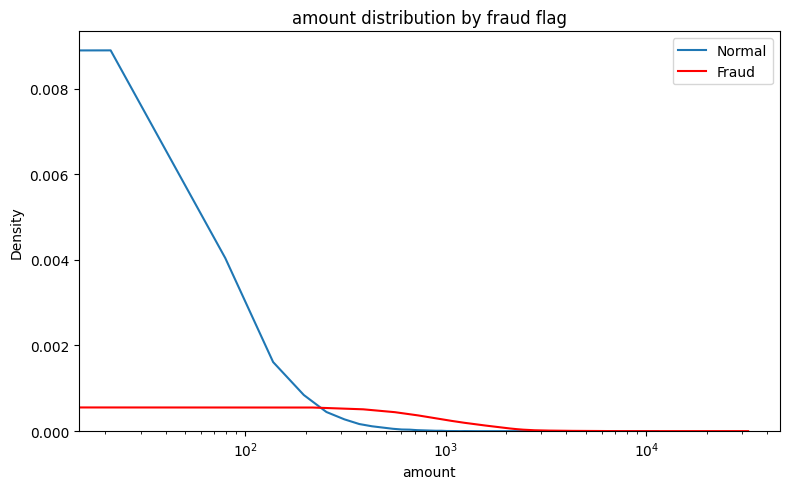

In [26]:
plt.figure(figsize = (8,5))
sns.kdeplot(df.loc[df['is_fraud'] == 0,'amount'],label ='Normal')
sns.kdeplot(df.loc[df['is_fraud'] == 1,'amount'],label ='Fraud', color = 'r')
plt.title('amount distribution by fraud flag')
plt.xlabel('amount')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

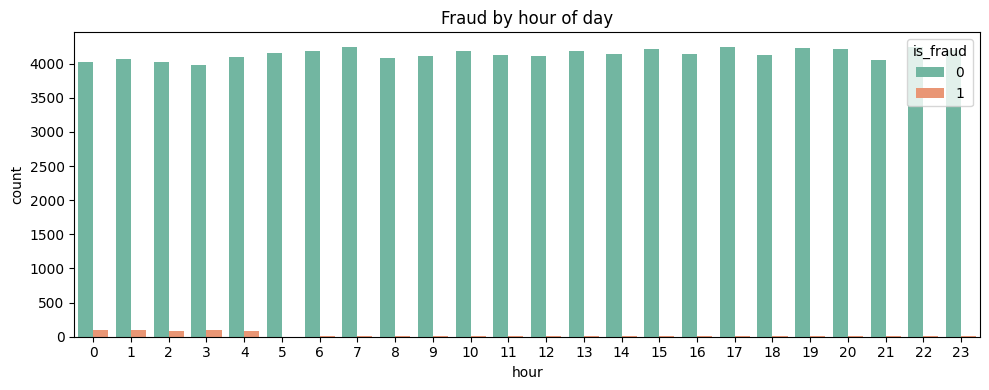

In [27]:
plt.figure(figsize = (10,4))
sns.countplot(data = df, x ='hour', hue = 'is_fraud', palette = 'Set2')
plt.title('Fraud by hour of day')
plt.tight_layout()
plt.show()

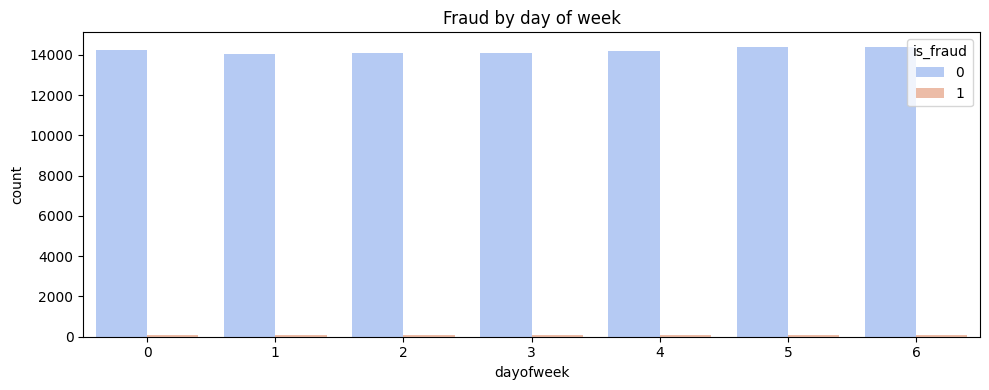

In [28]:
plt.figure(figsize = (10,4))
sns.countplot(data = df, x ='dayofweek', hue = 'is_fraud', palette = 'coolwarm',)
plt.title('Fraud by day of week')
plt.tight_layout()
plt.show()

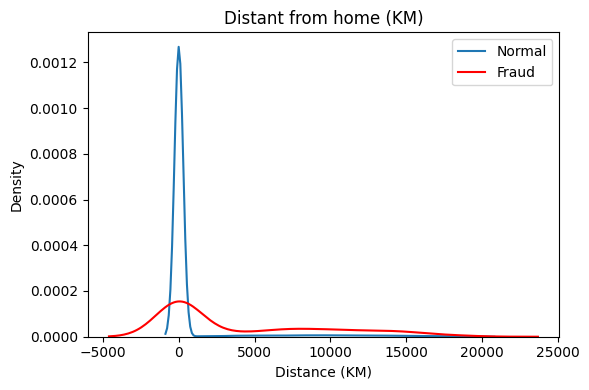

In [29]:
plt.figure(figsize = (6,4))
sns.kdeplot(df.loc[df['is_fraud'] == 0,'dist_from_home_km'],label ='Normal')
sns.kdeplot(df.loc[df['is_fraud'] == 1,'dist_from_home_km'],label ='Fraud', color = 'r')
plt.title('Distant from home (KM)')
plt.xlabel('Distance (KM)')

plt.legend()
plt.tight_layout()
plt.show()

In [30]:
fraud_geo = df.groupby('is_far_from_home')['is_fraud'].mean().rename('fraud_rate')
fraud_geo

is_far_from_home
0    0.003755
1    0.031435
Name: fraud_rate, dtype: float64

/var/folders/2y/tz8zxq155697bnfqw74v9rdh0000gn/T/ipykernel_34730/1816837635.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = df, x= 'payment_method', y = 'is_fraud', estimator = np.mean, ci = None)


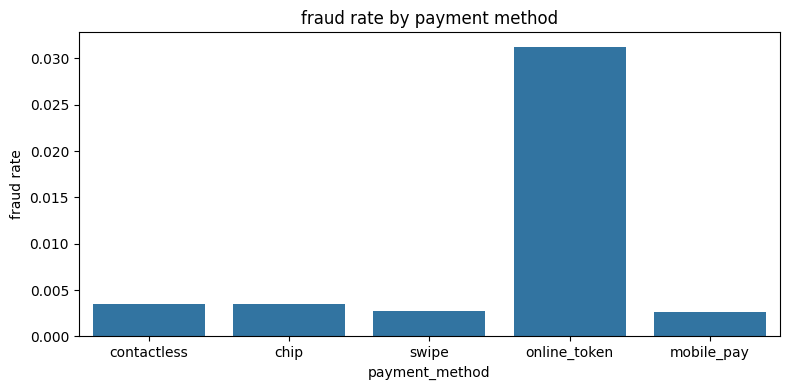

In [31]:
plt.figure(figsize = (8,4))
sns.barplot(data = df, x= 'payment_method', y = 'is_fraud', estimator = np.mean, ci = None)
plt.title('fraud rate by payment method')
plt.ylabel('fraud rate')


plt.tight_layout()
plt.show()

/var/folders/2y/tz8zxq155697bnfqw74v9rdh0000gn/T/ipykernel_34730/2498660212.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = df, x= 'device', y = 'is_fraud', estimator = np.mean, ci = None, order = df['device'].value_counts().index)


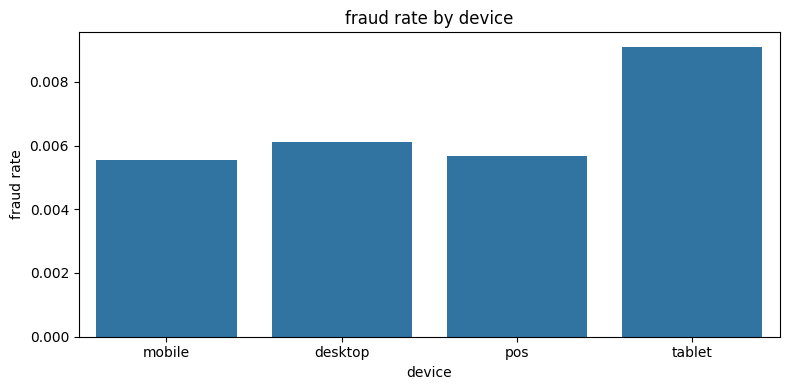

In [33]:
plt.figure(figsize = (8,4))
sns.barplot(data = df, x= 'device', y = 'is_fraud', estimator = np.mean, ci = None, order = df['device'].value_counts().index)
plt.title('fraud rate by device')
plt.ylabel('fraud rate')
plt.tight_layout()
plt.show()

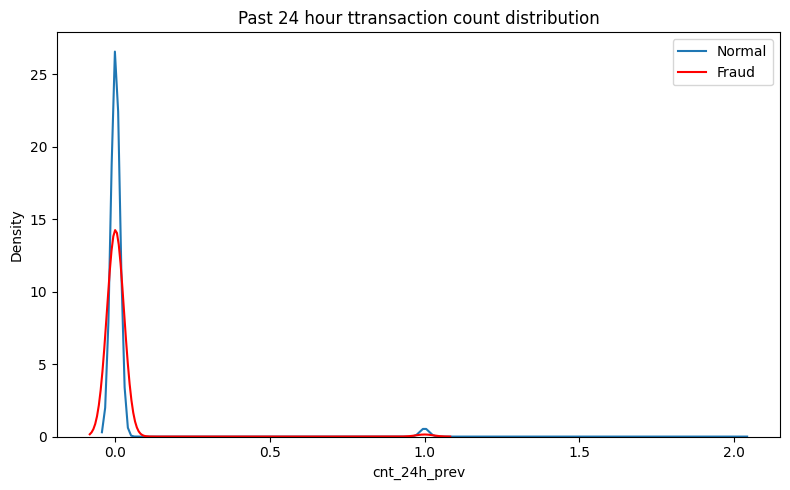

In [34]:
plt.figure(figsize = (8,5))
sns.kdeplot(df.loc[df['is_fraud'] == 0,'cnt_24h_prev'],label ='Normal')
sns.kdeplot(df.loc[df['is_fraud'] == 1,'cnt_24h_prev'],label ='Fraud', color = 'r')
plt.title('Past 24 hour ttransaction count distribution')
plt.legend()
plt.tight_layout()
plt.show()

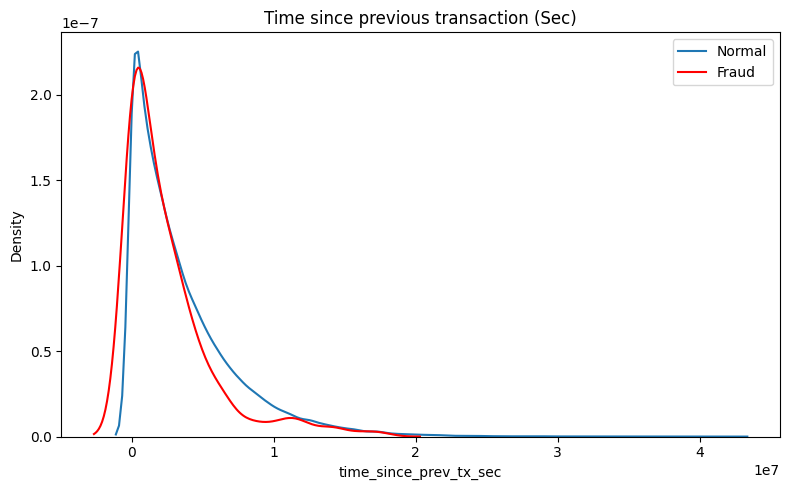

In [35]:
plt.figure(figsize = (8,5))
sns.kdeplot(df.loc[df['is_fraud'] == 0,'time_since_prev_tx_sec'],label ='Normal')
sns.kdeplot(df.loc[df['is_fraud'] == 1,'time_since_prev_tx_sec'],label ='Fraud', color = 'r')
plt.title('Time since previous transaction (Sec)')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/2y/tz8zxq155697bnfqw74v9rdh0000gn/T/ipykernel_34730/310381915.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = df, x= 'merchant_category', y = 'is_fraud', estimator = np.mean, ci = None)


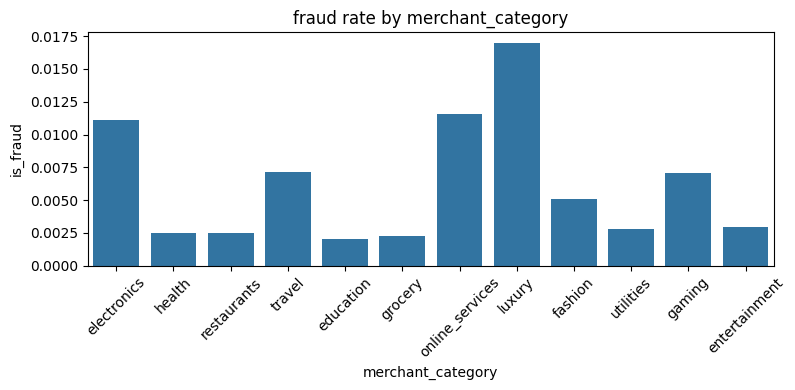

In [38]:
plt.figure(figsize = (8,4))
sns.barplot(data = df, x= 'merchant_category', y = 'is_fraud', estimator = np.mean, ci = None)
plt.title('fraud rate by merchant_category')
plt.xticks(rotation =45)


plt.tight_layout()
plt.show()

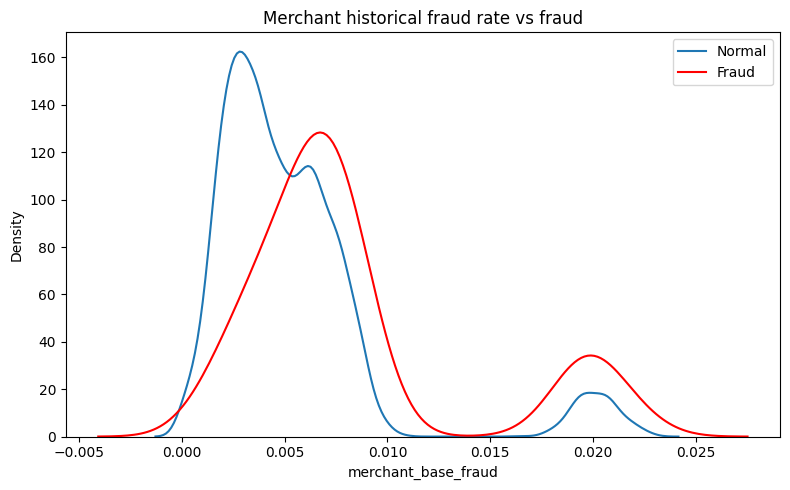

In [39]:
plt.figure(figsize = (8,5))
sns.kdeplot(df.loc[df['is_fraud'] == 0,'merchant_base_fraud'],label ='Normal')
sns.kdeplot(df.loc[df['is_fraud'] == 1,'merchant_base_fraud'],label ='Fraud', color = 'r')
plt.title('Merchant historical fraud rate vs fraud')
plt.legend()
plt.tight_layout()
plt.show()

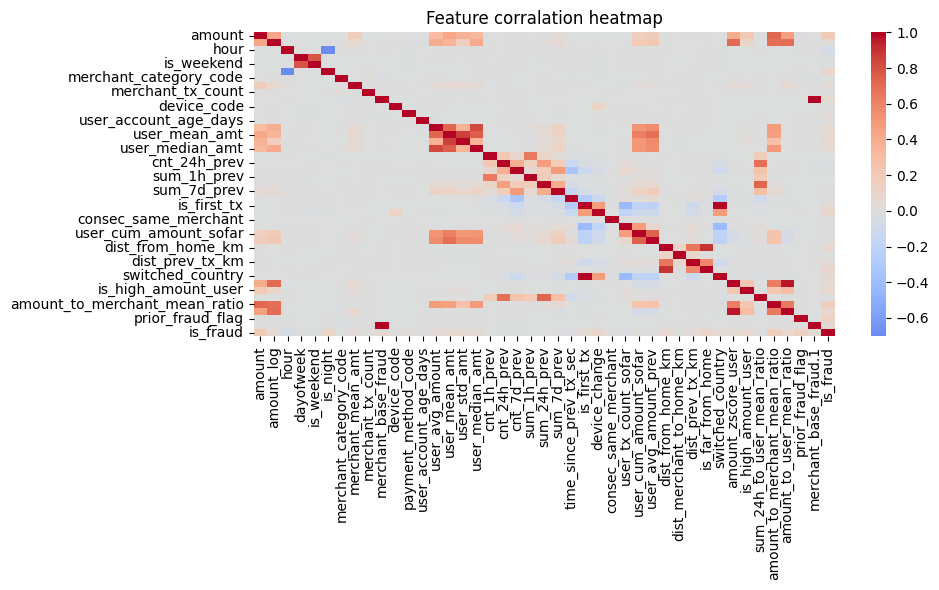

In [41]:
num_features = df.select_dtypes(include = [np.number])
corr = num_features.corr()['is_fraud'].sort_values(ascending = False)
corr.head(15)
plt.figure(figsize = (10,6))
sns.heatmap(num_features.corr(),cmap = 'coolwarm' , center = 0)
plt.title('Feature corralation heatmap')
plt.tight_layout()
plt.show()

In [1]:

def df_basic_time_features(df):
    dt = df['transaction_datetime']
    df['hour'] = dt.dt.hour
    df['dayofweek'] = dt.dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] >= 22 ) | (df['hour'] <= 6)).astype(int) 
    return df

In [3]:
def amount_features(df):
    df['amount_log'] = np.log1p(df['amount'].astype(float))
    df['amount_to_user_mean_ratio'] = df['amount'] / (df['user_avg_amount']+ 1e-6) 
    df['amount_to_merchant_mean_ratio'] =  df['amount'] / (df['merchant_mean_amount']+ 1e-6)
    return df



    
    

In [ ]:
def rolling_agg_features(df,user_col = 'user_id'):
    df = df.sort_values([user_col,'transaction_datetime']).copy()
    df['tmp_index'] = np.arange(len(df))
    df = df.set_index('tmp_index') 

    df['transaction_datetime'] = pd.to_datetime(df['transaction_datetime'])
    df = df.set_index('transaction_datetime')

    out = []
    for uid, g in df.groupby(user_col, group_keys = False):
        g = g.sort_index()
        for window in ['1h' , '24h', '7d']:
            g[f'cnt_{window}_prev'] = g['amount'].rolling(window = window, closed = 'left').count()
            g[f'sum_{window}_prev'] = g['amount'].rolling(window = window, closed = 'left').sum()
            g[f'mean_{window}_prev'] = g['amount'].rolling(window = window, closed = 'left').mean()
        out.append(g)
    df = pd.concat(out).reset_index()

    for col in df.columns:
        if col.startswith(('cnt_','sum_','mean_')):
            df[col] = df[col].fillna(0)
    return df

In [5]:
def sequence_features(df):
    df = df.sort_values(['user_id','transaction_datetime']).reset_index(drop = True)
    df['prev_tx_dt'] = df.groupby('userid')['transaction_datetime'].shift(1)
    df['time_since_prev_tx_sec'] = (df['transaction_datetime']- df['prev_tx_dt']).dt.total_seconds() 

    df['is_first_tx'] = df['prev_tx_dt'].isna().astype(int)

    df['pre_device'] = df.groupby('userid')['device'].shift(1)
    df['device_change'] = (df['device'] != df['pre_device']).astype(int)

    df['user_tx_count_sofar'] = df.groupby('user_id').cumcount()
    df['user_cum_amount_sofar'] = df.groupby('user_id')['amount'].cumcount() - df['amount']
    df['user_avg_amount_prev'] = df['user_avg_amount_prev'].fillna(df['user_avg_amount'])

    df['time_since_prev_tx_sec'] = df['time_since_prev_tx_sec'].fillna(-1)
    return df




In [7]:
def geolocation_features(df):
    if 'dist_from_home_km' in df.columns:
        df['is_far_from_home'] = (df['dist_from_home_km'] > 50).astype(int)
    df['prev_tx_dt'] = df.groupby('userid')['transaction_datetime'].shift(1)
    df['dist_prev_tx_km'] = df.get('dist_prev_tx_km', np.nan)
    df['time_delta_hours'] = (df['transaction_datetime']- df['prev_tx_dt']).dt.total_seconds() / 3600

    df['travel_speed_kmph'] = df['dist_prev_tx_km'] / df['time_delta_hours'].replace(0,np.nan)
    df['impossible_travel_flag'] = ((df['travel_speed_kmph'] > 500) & (~df['time_delta_hours'].isna())).astype(int)

    return df

In [2]:
def nomalize_and_encode(df, categorical_cols, scaler: StandardScaler=None) : 
    num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
    skip = ['is_fraud'] + ['transaction_id','user_id','merchant_id','transaction_datetime']
    num_cols =[c for c in num_cols if c not in skip]
    if scaler is None :
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols].fillna(0))
    else :
        df[num_cols] = scaler.transform(df[num_cols].fillna(0))

    label_encoders = {}
    for cols in categorical_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str).fillna('nan')
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, scaler,label_encoders